<a href="https://colab.research.google.com/github/dcymuller/crcns-student/blob/master/tutorials/W3D3_OptimalControl/student/W3D3_Tutorial1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial 1: Optimal Control for Discrete States

**Week 3, Day 3: Optimal Control**

**By Neuromatch Academy**

__Content creators:__ Zhengwei Wu, Itzel Olivos Castillo, Shreya Saxena, Xaq Pitkow

__Content reviewers:__ Karolina Stosio, Roozbeh Farhoodi, Saeed Salehi, Ella Batty, Spiros Chavlis, Matt Krause, Michael Waskom, Melisa Maidana Capitan

<p align='center'><img src='https://github.com/NeuromatchAcademy/widgets/blob/master/sponsors.png?raw=True'/></p>

---
# Tutorial Objectives

*Estimated timing of tutorial: 60 min*

In this tutorial, we will implement a **binary control** task: a Partially Observable Markov Decision Process (POMDP) that describes fishing. The agent (you) seeks reward from two fishing sites without directly observing where the school of fish is (yes, a group of fish is called a school!). This makes the world a Hidden Markov Model (HMM), just like in the *Hidden Dynamics* day. Based on when and where you catch fish, you keep updating your belief about the fish location, i.e., the posterior of the fish given past observations. You should control your position to get the most fish while minimizing the cost of switching sides.

You've already learned about stochastic dynamics, latent states, and measurements. These first exercises largely repeat your previous work. Now we introduce **actions**, based on the new concepts of **control, utility, and policy**. This general structure provides a foundational model for the brain's computations because it includes a perception-action loop where the animal can gather information, draw inferences about its environment, and select actions with the greatest benefit. *How*, mechanistically, the neurons could actually implement these calculations is a separate question we don't address in this lesson.

In this tutorial, you will:
* Use the Hidden Markov Models you learned about previously to model the world state.
* Use the observations (fish caught) to build beliefs (posterior distributions) about the fish location.
* Evaluate the quality of different control policies for choosing actions.
* Discover the policy that maximizes utility.

In [ ]:
# @title Tutorial slides

# @markdown These are the slides for all videos in this tutorial.
from IPython.display import IFrame
IFrame(src="https://mfr.ca-1.osf.io/render?url=https://osf.io/8j5rs/?direct%26mode=render%26action=download%26mode=render", width=854, height=480)

---
## Setup  



In [1]:
# Imports
import numpy as np
from math import isclose
import matplotlib.pyplot as plt

In [2]:
# @title Figure Settings
import ipywidgets as widgets
from IPython.display import HTML
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

In [3]:
# @title Plotting Functions

def plot_fish(fish_state, ax=None):
  """
  Plot the fish dynamics (states across time)
  """
  T = len(fish_state)

  offset = 3

  if not ax:
    fig, ax = plt.subplots(1, 1, figsize=(12, 3.5))

  x = np.arange(0, T, 1)
  y = offset * (fish_state*2 - 1)

  ax.plot(y, color='cornflowerblue', markersize=10, linewidth=3.0, zorder=0)
  ax.fill_between(x, y, color='cornflowerblue', alpha=.3)

  ax.set_xlabel('time')
  ax.set_ylabel('fish location')

  ax.set_xlim([0, T])
  ax.set_xticks([])
  ax.xaxis.set_label_coords(1.05, .54)

  ax.set_ylim([-(offset+.5), offset+.5])
  ax.set_yticks([-offset, offset])
  ax.set_yticklabels(['left', 'right'])

  ax.spines['bottom'].set_position('center')
  # plt.savefig('fish_loc.pdf')


def plot_measurement(measurement, ax=None):
  """
  Plot the measurements
  """
  T = len(measurement)

  rel_pos = 3
  red_y = []
  blue_y = []
  for idx, value in enumerate(measurement):
    if value == 0:
      blue_y.append([idx, -rel_pos])
    else:
      red_y.append([idx, rel_pos])

  red_y = np.asarray(red_y)
  blue_y = np.asarray(blue_y)

  if not ax:
    fig, ax = plt.subplots(1, 1, figsize=(12, 3.5))

  if len(red_y) > 0:
    ax.plot(red_y[:, 0], red_y[:, 1], '*', markersize=8, color='crimson')

  if len(blue_y) > 0:
    ax.plot(blue_y[:, 0], blue_y[:, 1], '*', markersize=8, color='royalblue')

  ax.set_xlabel('time', fontsize=18)
  ax.set_ylabel('Caught fish?')

  ax.set_xlim([0, T])
  ax.set_xticks([])
  ax.xaxis.set_label_coords(1.05, .54)

  ax.set_ylim([-rel_pos - .5, rel_pos + .5])
  ax.set_yticks([-rel_pos, rel_pos])
  ax.set_yticklabels(['no', 'yes!'])

  ax.spines['bottom'].set_position('center')
  # plt.savefig('measurement.pdf')


def plot_act_loc(loc, act, ax_loc=None):
  """
  Plot the action and location of T time points
  """
  T = len(act)

  if not ax_loc:
    fig, ax_loc = plt.subplots(1, 1, figsize=(12, 2.5))

  loc = loc*2 - 1
  act_down = []
  act_up = []
  for t in range(1, T):
    if loc[t-1] == -1 and loc[t] == 1:
      act_up.append([t - 0.5, 0])
    if loc[t-1] == 1 and loc[t] == -1:
      act_down.append([t - 0.5, 0])

  act_down = np.array(act_down)
  act_up = np.array(act_up)

  ax_loc.plot(loc, 'g.-', markersize=8, linewidth=5)

  if len(act_down) > 0:
    ax_loc.plot(act_down[:, 0], act_down[:, 1], 'rv', markersize=18, zorder=10, label='switch')

  if len(act_up) > 0:
    ax_loc.plot(act_up[:, 0], act_up[:, 1], 'r^', markersize=18, zorder=10)

  ax_loc.set_xlabel('time')
  ax_loc.set_ylabel('Your state')

  ax_loc.set_xlim([0, T])
  ax_loc.set_xticks([])
  ax_loc.xaxis.set_label_coords(1.05, .54)

  if len(act_down) > 0:
    ax_loc.legend(loc="upper right")
  elif len(act_down) == 0 and len(act_up) > 0:
    ax_loc.plot(act_up[:, 0], act_up[:, 1], 'r^', markersize=18, zorder=10, label='switch')
    ax_loc.legend(loc="upper right")





  ax_loc.set_ylim([-1.1, 1.1])
  ax_loc.set_yticks([-1, 1])

  ax_loc.tick_params(axis='both', which='major')
  ax_loc.set_yticklabels(['left', 'right'])

  ax_loc.spines['bottom'].set_position('center')


def plot_belief(belief, ax1=None, choose_policy=None):
  """
  Plot the belief dynamics of T time points
  """

  T = belief.shape[1]

  if not ax1:
      fig, ax1 = plt.subplots(1, 1, figsize=(12, 2.5))

  ax1.plot(belief[1, :], color='midnightblue', markersize=10, linewidth=3.0)

  ax1.set_xlabel('time')
  ax1.set_ylabel('Belief (right)')

  ax1.set_xlim([0, T])
  ax1.set_xticks([])
  ax1.xaxis.set_label_coords(1.05, 0.05)

  ax1.set_yticks([0, 1])
  ax1.set_ylim([0, 1.1])

  labels = [item.get_text() for item in ax1.get_yticklabels()]
  ax1.set_yticklabels(['    0', '    1'])

  """
  if choose_policy == "threshold":
    ax2 = ax1.twinx()
    ax2.plot(time_range, threshold * np.ones(time_range.shape), 'r--')
    ax2.plot(time_range, (1 - threshold) * np.ones(time_range.shape), 'c--')
    ax2.set_yticks([threshold, 1 - threshold])
    ax2.set_ylim([0, 1.1])
    ax2.tick_params(axis='both', which='major', labelsize=18)
    labels = [item.get_text() for item in ax2.get_yticklabels()]
    labels[0] = 'threshold to switch \n from left to right'
    labels[-1] = 'threshold to switch \n from right to left'
    ax2.set_yticklabels(labels)
  """


def plot_dynamics(belief, loc, act, meas, fish_state, choose_policy):
  """
  Plot the dynamics of T time points
  """
  if choose_policy == 'threshold':
    fig, [ax0, ax_bel, ax_loc, ax1] = plt.subplots(4, 1, figsize=(12, 9))
    plot_fish(fish_state, ax=ax0)
    plot_belief(belief, ax1=ax_bel)
    plot_measurement(meas, ax=ax1)
    plot_act_loc(loc, act, ax_loc=ax_loc)
  else:
    fig, [ax0, ax_bel, ax1] = plt.subplots(3, 1, figsize=(12, 7))
    plot_fish(fish_state, ax=ax0)
    plot_belief(belief, ax1=ax_bel)
    plot_measurement(meas, ax=ax1)

  plt.tight_layout()
  #plt.savefig('active dynamics.pdf')
  plt.show()


def belief_histogram(belief, bins=100):
  """
  Plot the histogram of belief states
  """
  fig, ax = plt.subplots(1, 1, figsize=(8, 6))
  ax.hist(belief, bins)
  ax.set_xlabel('belief', fontsize=18)
  ax.set_ylabel('count', fontsize=18)
  plt.show()


def plot_value_threshold(threshold_array, value_array):
  """
  Helper function to plot the value function and threshold
  """
  yrange = np.max(value_array) - np.min(value_array)
  star_loc = np.argmax(value_array)

  fig_, ax = plt.subplots(1, 1, figsize=(8, 6))
  ax.plot(threshold_array, value_array, 'b')
  ax.vlines(threshold_array[star_loc],
            min(value_array) - yrange * .1, max(value_array),
            colors='red', ls='--')
  ax.plot(threshold_array[star_loc],
          value_array[star_loc],
          '*', color='crimson',
          markersize=20)

  ax.set_ylim([np.min(value_array) - yrange * .1,
               np.max(value_array) + yrange * .1])
  ax.set_title(f'threshold vs value with switching cost c = {cost_sw:.2f}',
               fontsize=20)
  ax.set_xlabel('threshold', fontsize=16)
  ax.set_ylabel('value', fontsize=16)
  plt.show()

In [4]:
# @title Helper Functions

# To generate a binomial with fixed "noise",
# we generate a sequence of T numbers uniformly at random
T = 100

rnd_tele = np.random.uniform(0, 1, T)
rnd_high_rwd = np.random.uniform(0, 1, T)
rnd_low_rwd = np.random.uniform(0, 1, T)


def get_randomness(T):
  global rnd_tele
  global rnd_high_rwd
  global rnd_low_rwd

  rnd_tele = np.random.uniform(0, 1, T)
  rnd_high_rwd = np.random.uniform(0, 1, T)
  rnd_low_rwd = np.random.uniform(0, 1, T)


def binomial_tele(p):
  return np.array([1 if p > rnd_tele[i] else 0 for i in range(T)])


def getRandomness(p, largeT):
  global rnd_tele
  global rnd_high_rwd
  global rnd_low_rwd

  rnd_tele = np.random.uniform(0, 1, largeT)
  rnd_high_rwd = np.random.uniform(0, 1, largeT)
  rnd_low_rwd = np.random.uniform(0, 1, largeT)

  return [np.array([1 if p > rnd_tele[i] else 0 for i in range(T)]),
          rnd_high_rwd, rnd_low_rwd]

# def binomial_high_rwd(p):
#   return np.array([1 if p > rnd_high_rwd[i] else 0 for i in range(T)])

# def binomial_low_rwd(p):
#   return np.array([1 if p > rnd_low_rwd[i] else 0 for i in range(T)])


class ExcerciseError(AssertionError):
  pass


class binaryHMM():

  def __init__(self, params, fish_initial=0, loc_initial=0):
    self.params = params
    self.fish_initial = fish_initial
    self.loc_initial = loc_initial

  def fish_dynamics(self):
    """
    fish state dynamics according to telegraph process

    Returns:
      fish_state (numpy array of int)
    """
    p_stay, _, _, _ = self.params
    fish_state = np.zeros(T, int)  # 0: left side and 1: right side

    # initialization
    fish_state[0] = self.fish_initial
    tele_operations = binomial_tele(p_stay) # 0: switch and 1: stay

    for t in range(1, T):
      # we use logical operation NOT XOR to determine the next state
      fish_state[t] = int(not(fish_state[t-1] ^ tele_operations[t]))

    return fish_state

  def generate_process_lazy(self):
    """
    fish dynamics and rewards if you always stay in the initial location
    without changing sides

    Returns:
      fish_state (numpy array of int): locations of the fish
      loc (numpy array of int): left or right site, 0 for left, and 1 for right
      rwd (numpy array of binary): whether a fish was catched or not
    """

    _, p_low_rwd, p_high_rwd, _ = self.params

    fish_state = self.fish_dynamics()
    rwd = np.zeros(T, int)  # 0: no food, 1: get food

    for t in range(0, T):
      # new measurement
      if fish_state[t] != self.loc_initial:
        rwd[t] = 1 if p_low_rwd > rnd_low_rwd[t] else 0
      else:
        rwd[t] = 1 if p_high_rwd > rnd_high_rwd[t] else 0

      # rwd[t] = binomial(1, p_rwd_vector[(fish_state[t] == loc[t]) * 1])
    return fish_state, self.loc_initial*np.ones(T), rwd


class binaryHMM_belief(binaryHMM):

  def __init__(self, params,
               fish_initial=0, loc_initial=1,
               choose_policy='threshold'):

      binaryHMM.__init__(self, params, fish_initial, loc_initial)
      self.choose_policy = choose_policy

  def generate_process(self):
    """
    fish dynamics and measurements based on the chosen policy

    Returns:
      belief (numpy array of float): belief on the states of the two sites
      act (numpy array of string): actions over time
      loc (numpy array of int): left or right site
      measurement (numpy array of binary): whether a reward is obtained
      fish_state (numpy array of int): fish locations
    """

    p_stay, low_rew_p, high_rew_p, threshold = self.params
    fish_state = self.fish_dynamics()     # 0: left side; 1: right side
    loc = np.zeros(T, int)                # 0: left side, 1: right side
    measurement = np.zeros(T, int)        # 0: no food, 1: get food
    act = np.empty(T, dtype='object')     # "stay", or "switch"
    belief = np.zeros((2, T), float)      # the probability that the fish is on the left (1st element)
                                          # or on the right (2nd element),
                                          # the beliefs on the two boxes sum up to be 1

    rew_prob = np.array([low_rew_p, high_rew_p])

    # initialization
    loc[0] = self.loc_initial
    measurement[0] = 0
    belief_0 = np.random.random(1)[0]
    belief[:, 0] = np.array([belief_0, 1 - belief_0])
    act[0] = self.policy(threshold, belief[:, 0], loc[0])

    for t in range(1, T):
      if act[t - 1] == "stay":
          loc[t] = loc[t - 1]
      else:
          loc[t] = int(not(loc[t - 1] ^ 0))

      # new measurement
      # measurement[t] = binomial(1, rew_prob[(fish_state[t] == loc[t]) * 1])
      if fish_state[t] != loc[t]:
          measurement[t] = 1 if low_rew_p > rnd_low_rwd[t] else 0
      else:
          measurement[t] = 1 if high_rew_p > rnd_high_rwd[t] else 0

      belief[0, t] = self.belief_update(belief[0, t - 1] , loc[t],
                                        measurement[t], p_stay,
                                        high_rew_p, low_rew_p)
      belief[1, t] = 1 - belief[0, t]

      act[t] = self.policy(threshold, belief[:, t], loc[t])

    return belief, loc, act, measurement, fish_state

  def policy(self, threshold, belief, loc):
    """
    chooses policy based on whether it is lazy policy
        or a threshold-based policy

    Args:
      threshold (float): the threshold of belief on the current site,
          when the belief is lower than the threshold, switch side
      belief (numpy array of float): the belief on the two sites
      loc (int) : the location of the agent

    Returns:
      act (string): "stay" or "switch"
    """
    if self.choose_policy == "threshold":
      act = policy_threshold(threshold, belief, loc)
    if self.choose_policy == "lazy":
      act = policy_lazy(belief, loc)

    return act

  def belief_update(self, belief_past, loc, measurement, p_stay,
                    high_rew_p, low_rew_p):
    """
    using PAST belief on the LEFT box, CURRENT location and
        and measurement to update belief
    """
    rew_prob_matrix = np.array([[1 - high_rew_p, high_rew_p],
                                [1 - low_rew_p, low_rew_p]])

    # update belief posterior, p(s[t] | measurement(0-t), act(0-t-1))
    belief_0 = (belief_past * p_stay  + (1 - belief_past) * (1 - p_stay)) *\
                            rew_prob_matrix[(loc + 1) // 2, measurement]
    belief_1 = ((1 - belief_past) * p_stay + belief_past * (1 - p_stay)) *\
                            rew_prob_matrix[1-(loc + 1) // 2, measurement]

    belief_0 = belief_0 / (belief_0 + belief_1)

    return belief_0


def policy_lazy(belief, loc):
  """
  This function is a lazy policy where stay is also taken
  """
  act = "stay"

  return act


def test_policy_threshold():
  well_done = True
  for loc in [-1, 1]:
    threshold = 0.4
    belief = np.array([.2, .3])
    if policy_threshold(threshold, belief, loc) != "switch":
      raise ExcerciseError("'policy_threshold' function is not correctly implemented!")
  for loc in [1, -1]:
    threshold = 0.6
    belief = np.array([.7, .8])
    if policy_threshold(threshold, belief, loc) != "stay":
      raise ExcerciseError("'policy_threshold' function is not correctly implemented!")
  print("Well Done!")


def test_policy_threshold():
  for loc in [-1, 1]:
    threshold = 0.4
    belief = np.ones(2) * (threshold + 0.1)
    belief[(loc + 1) // 2] = threshold - 0.1

    if policy_threshold(threshold, belief, loc) != "switch":
      raise ExcerciseError("'policy_threshold' function is not correctly implemented!")
    if policy_threshold(threshold, belief, -1 * loc) != "stay":
      raise ExcerciseError("'policy_threshold' function is not correctly implemented!")

  print("Well Done!")


def test_value_function():
  measurement = np.array([0, 0, 0, 1, 0, 0, 0, 0, 1, 1])
  act = np.array(["switch", "stay", "switch", "stay", "stay",
                  "stay", "switch", "switch", "stay", "stay"])
  cost_sw = .5
  if not isclose(get_value(measurement, act, cost_sw), .1):
    raise ExcerciseError("'value_function' function is not correctly implemented!")
  print("Well Done!")

---
# Section 1: Analyzing the Problem

In [5]:
# @title Video 1: Gone fishing
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
      def __init__(self, id, page=1, width=400, height=300, **kwargs):
          self.id=id
          src = 'https://player.bilibili.com/player.html?bvid={0}&page={1}'.format(id, page)
          super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id="BV1FL411p7o5", width=854, height=480, fs=1)
  print('Video available at https://www.bilibili.com/video/{0}'.format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id="3oIwUFpolVA", width=854, height=480, fs=1, rel=0)
  print('Video available at https://youtube.com/watch?v=' + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

display(out)

**Problem Setting**

*1. State dynamics:* There are two possible locations for the fish: Left and Right. Secretly, at each time step, the fish may switch sides with a certain probability $p_{\rm sw} = 1 - p_{\rm stay}$. This is the binary switching model (*Telegraph process*) that you've seen in the *Linear Systems* day. The fish location, $s^{\rm fish}$, is latent; you get measurements about it when you try to catch fish, like in the *Hidden Dynamics* day. This gives you a *belief* or posterior probability of the current location given your history of measurements.

*2. Actions:* Unlike past days, you can now **act** on the process! You may stay on your current location (Left or Right), or switch to the other side.

*3. Rewards and Costs:* You get rewarded for each fish you catch (one fish is worth 1 "point"). If you're on the same side as the fish, you'll catch more, with probability $q_{\rm high}$ per discrete time step. Otherwise, you may still catch some fish with probability $q_{\rm low}$. 

You pay a price of $C$ points for switching to the other side. So you better decide wisely!

<br>

**Maximizing Utility**

To decide "wisely" and maximize your total utility (total points), you will follow a **policy** that prescribes what to do in any situation. Here the situation is determined by your location and your **belief** $b_t$ (posterior) about the fish location (remember that the fish location is a latent variable). 

In optimal control theory, the belief is the posterior probability over the latent variable given all the past measurements. It can be shown that maximizing the expected utility with respect to this posterior is optimal.

In our problem, the belief can be represented by a single number because the fish are either on the left or the right side. So we write: 

\begin{equation}
b_t = p(s^{\rm fish}_t = {\rm Right}\  |\  m_{0:t}, a_{0:t-1})
\end{equation}

where $m_{0:t}$ are the measurements and $a_{0:t-1}$ are the actions (stay or switch).

Finally, we will parameterize the policy by a simple threshold on beliefs: when your belief that fish are on your current side falls below a threshold $\theta$, you switch to the other side.

In this tutorial, you will discover that if you pick the right threshold, this simple policy happens to be optimal!

## Interactive Demo 1: Examining fish dynamics

In this demo, we will look at the dynamics of the fish moving from side to side while you stay in one place. Play around with the probability `stay_prob` of fish staying in the same location, and observe the resulting dynamics of the fish.

**Thinking questions:**

* If the fish have already been on one side for a long time, does that change the chances of them switching sides?
* For what values of p_stay is the fish location most and least predictable?

In [6]:
# @markdown Execute this cell to enable the demo.
display(HTML('''<style>.widget-label { min-width: 15ex !important; }</style>'''))

@widgets.interact(p_stay=widgets.FloatSlider(.9, description="stay_prob", min=0., max=1., step=0.01))

def update_ex_1(p_stay):
  """
    T: Length of timeline
    p_stay: probability that the fish do not swim to the other side at time t
  """
  params = [p_stay, _, _, _]

  #### initial condition: fish [fish_initial] start at the left location (-1) ####
  binaryHMM_test = binaryHMM(params=params, fish_initial=1)

  fish_state = binaryHMM_test.fish_dynamics()
  plot_fish(fish_state)

plt.show()

interactive(children=(FloatSlider(value=0.9, description='stay_prob', max=1.0, step=0.01), Output()), _dom_cla…

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/main//tutorials/W3D3_OptimalControl/solutions/W3D3_Tutorial1_Solution_c99bf907.py)



---
# Section 2: Catching fish

In [7]:
# @title Video 2: Catch some fish
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
      def __init__(self, id, page=1, width=400, height=300, **kwargs):
          self.id=id
          src = 'https://player.bilibili.com/player.html?bvid={0}&page={1}'.format(id, page)
          super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id="BV1kD4y1m7Lo", width=854, height=480, fs=1)
  print('Video available at https://www.bilibili.com/video/{0}'.format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id="ZjB2_SAY2uE", width=854, height=480, fs=1, rel=0)
  print('Video available at https://youtube.com/watch?v=' + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

display(out)

## Interactive Demo 2: Examining the reward function

In this second demo, you control your location by a button, but we fix the fish's location by setting `stay_prob = 1`. Now that the fish are serenely swimming in one location, we can visually inspect the rewards when you're on the same side as the fish or on the other side.

When you're on the same side as the fish, you should have a higher probability of catching them (but watch out, since technically, you are _allowed_ to adjust the sliders to other conditions!).

Play around with the sliders `high_rew_prob` (high reward probability when you're on the fish's side) and `low_rew_prob` (low reward probability when you're on the other side). The button (same location *vs.* different location) determines which probability describes how often you catch fish.

**Thinking questions:**

* What happens when the fish and the agent (you!) are on the same or different locations?
* Where do you catch the most fish?
* Why isn't `low_rew_prob + high_rew_prob = 1`? What do these probabilities mean in the fishing story?
* You _can_ move the sliders so `low_rew_prob > high_rew_prob`. This doesn't change the math, but it can change whether the math is a reasonable model of the physical problem. Why?

In [8]:
# @markdown Execute this cell to enable the demo.
display(HTML('''<style>.widget-label { min-width: 15ex !important; }</style>'''))

@widgets.interact(locs=widgets.RadioButtons(options=['same location', 'different locations'],
                                            description='Fish and agent:',
                                            disabled=False,
                                            layout={'width': 'max-content'}),
                  p_low_rwd=widgets.FloatSlider(.1, description="low_rew_prob:", min=0., max=1.),
                  p_high_rwd=widgets.FloatSlider(.9, description="high_rew_prob:", min=0., max=1.))

def update_ex_2(locs, p_low_rwd, p_high_rwd):
  """
    p_stay: probability of fish staying at current side at time t
    p_low_rwd: probability of catching fish when you're NOT on the side where the fish are swimming
    p_high_rwd: probability of catching fish when you're on the side where the fish are swimming
    fish_initial: initial side of fish (-1 left, 1 right)
    agent_initial: initial side of the agent (YOU!) (-1 left, 1 right)
  """
  p_stay = 1
  params = [p_stay, p_low_rwd, p_high_rwd, _]

  #### initial condition for fish [fish_initial] and you [loc_initial] ####
  if locs == 'same location':
      binaryHMM_test = binaryHMM(params, fish_initial=0, loc_initial=0)
  else:
      binaryHMM_test = binaryHMM(params, fish_initial=1, loc_initial=0)

  fish_state, loc, measurement = binaryHMM_test.generate_process_lazy()
  plot_measurement(measurement)

plt.show()

interactive(children=(RadioButtons(description='Fish and agent:', layout=Layout(width='max-content'), options=…

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/main//tutorials/W3D3_OptimalControl/solutions/W3D3_Tutorial1_Solution_05cc8353.py)



---
# Section 3: Belief dynamics and belief distributions

In [9]:
# @title Video 3: Where are the fish?
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
      def __init__(self, id, page=1, width=400, height=300, **kwargs):
          self.id=id
          src = 'https://player.bilibili.com/player.html?bvid={0}&page={1}'.format(id, page)
          super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id="BV19t4y1Q7VH", width=854, height=480, fs=1)
  print('Video available at https://www.bilibili.com/video/{0}'.format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id="rmETVsRFYGk", width=854, height=480, fs=1, rel=0)
  print('Video available at https://youtube.com/watch?v=' + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

display(out)

## Interactive Demo 3: Examining the beliefs

Now it's time to get an intuition on how beliefs are calculated. Here we define your belief about the fish location is just the posterior probability about that location given your measurements, $p(s_t|m_{0:t})$. Note that this is just what you did in the day covering Hidden Dynamics!

In this exercise, you'll always stay on the LEFT side, but the fish will move around. They'll stay on the same side with probability `stay_prob`. You only get to see fish you catch, not where the school of fish is. You have to use those measurements to infer the location of the school.

In this demo, play around with the sliders `high_rew_prob` and `low_rew_prob`, and `stay_prob`.

**Thinking questions:**

* Manipulate the slider for `stay_prob`. How well does the belief explain the dynamics of the fish as you adjust the probability of the fish staying in one location (`stay_prob`)?

* Explore the extreme case where `high_rew_prob = 1` and `low_rew_prob = 0`. How accurate is the belief as these parameters change?

* Under what conditions is it informative to catch a fish? What about to *not* catching a fish?

In [11]:
# @markdown Execute this cell to enable the demo.
display(HTML('''<style>.widget-label { min-width: 15ex !important; }</style>'''))

@widgets.interact(p_stay=widgets.FloatSlider(.96, description="stay_prob", min=0, max=1., step=.01),
                  p_low_rwd=widgets.FloatSlider(.1, description="low_rew_prob", min=0., max=1., step=.01),
                  p_high_rwd=widgets.FloatSlider(.3, description="high_rew_prob", min=0., max=1., step=.01))

def update_ex_2(p_stay, p_low_rwd, p_high_rwd):
  """
    T: Length of timeline
    p_stay: probability of fish staying at current side at time t
    p_high_rwd: probability of catching fish when you're on the side where the fish are swimming
    p_low_rwd: probability of catching fish when you're NOT on the side where the fish are swimming
    fish_initial: initial side of fish (0 left, 1 right)
    agent_initial: initial side of the agent (YOU!) (0 left, 1 right)
    threshold: threshold of belief below which the action is switching
  """
  threshold = 0.2
  params = [p_stay, p_low_rwd, p_high_rwd, threshold]

  binaryHMM_test = binaryHMM_belief(params, choose_policy="lazy",
                                    fish_initial=0, loc_initial=0)

  belief, loc, act, measurement, fish_state = binaryHMM_test.generate_process()
  plot_dynamics(belief, loc, act, measurement, fish_state,
                binaryHMM_test.choose_policy)

plt.show()

interactive(children=(FloatSlider(value=0.96, description='stay_prob', max=1.0, step=0.01), FloatSlider(value=…

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/main//tutorials/W3D3_OptimalControl/solutions/W3D3_Tutorial1_Solution_e2ef7c27.py)



---
# Section 4: Implementing a threshold policy

In [12]:
# @title Video 4: How should you act?
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
      def __init__(self, id, page=1, width=400, height=300, **kwargs):
          self.id=id
          src = 'https://player.bilibili.com/player.html?bvid={0}&page={1}'.format(id, page)
          super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id="BV1ri4y137cj", width=854, height=480, fs=1)
  print('Video available at https://www.bilibili.com/video/{0}'.format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id="cTzaQl2Vxn4", width=854, height=480, fs=1, rel=0)
  print('Video available at https://youtube.com/watch?v=' + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

display(out)

## Coding Exercise 4: dynamics following a **threshold-based** policy.

Now we'll switch the policy from the 'lazy' policy used above to a threshold policy that you need to write. You'll change your location whenever your belief is low enough that you're on the best side. You'll update the function `policy_threshold(threshold, belief, loc)`. This policy takes three inputs: 

1. The `belief` about the fish state. For convenience, we will represent the belief at time *t* using a 2-dimensional vector. The first element is the belief that the fish are on the left, and the second element is the belief the fish are on the right. At every time step, these elements sum to 1.

2. Your location `loc`, represented as "Left" = -1 and "Right" = 1. 

3. A belief `threshold` that determines when to switch. When your belief that you are on the same side as the fish drops below this threshold, you should move to the other location, and otherwise stay.

Your function should return an action for each time *t*, which takes the value of "stay" or "switch".

In [15]:
def policy_threshold(threshold, belief, loc):
  """
  chooses whether to switch side based on whether the belief
      on the current site drops below the threshold

  Args:
    threshold (float): the threshold of belief on the current site,
                        when the belief is lower than the threshold, switch side
    belief (numpy array of float, 2-dimensional): the belief on the
                                                  two sites at a certain time
    loc (int) : the location of the agent at a certain time
                -1 for left side, 1 for right side

  Returns:
    act (string): "stay" or "switch"
  """

  ############################################################################
  ## 1. Modify the code below to generate actions (stay or switch)
  ##    for current belief and location
  ##
  ## Belief is a 2d vector: first element = Prob(fish on Left | measurements)
  ##                       second element = Prob(fish on Right  | measurements)
  ## Returns "switch" if Belief that fish are in your current location < threshold
  ##         "stay" otherwise
  ##
  ## Hint: use loc value to determine which row of belief you need to use
  ##       see the docstring for more information about loc
  ##
  ## 2. After completing the function, comment this line:
  #raise NotImplementedError("Student exercise: Please complete the code")
  ############################################################################
  # Write the if statement
  if (belief[int((loc+1)/2)] < threshold):
    # action below threshold
    act = "switch"
  else:
    # action above threshold
    act = "stay"

  return act


# Next line tests your function
test_policy_threshold()

Well Done!


[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/main//tutorials/W3D3_OptimalControl/solutions/W3D3_Tutorial1_Solution_b5b3b278.py)



## Interactive Demo 4: Dynamics with different thresholds

The following demo uses the policy you just built! Play around with the slider and observe the dynamics controlled by your policy.

(The code specifies `stay_prob=0.95`, `high_rew_prob=0.3`, and `low_rew_prob=0.1`. You can change these, but these are reasonable parameters. Note: to see the gradual change with threshold, keep reusing the same random; to see different examples, refresh the seed.
)

**Thinking questions:**
* Qualitatively, how well does this policy follow the fish? What does it miss, and why?
* How can you characterize the fishing strategy if the threshold is very low, or very high?

In [16]:
# @markdown Execute this cell to enable the demo.
display(HTML('''<style>.widget-label { min-width: 15ex !important; }</style>'''))

@widgets.interact(threshold=widgets.FloatSlider(.2, description="threshold", min=0., max=1., step=.01),
                  new_seed=widgets.ToggleButtons(options=['Reusing', 'Refreshing'],
                                                  description='Random seed:',
                                                  disabled=False,
                                                  button_style='', # 'success', 'info', 'warning', 'danger' or '',
                                                  icons=['check'] * 2
                                                  ))
def update_ex_4(threshold, new_seed):
  """
    p_stay: probability fish stay
    high_rew_p: p(catch fish) when you're on their side
    low_rew_p : p(catch fish) when you're on other side
    threshold: threshold of belief below which switching is taken

  """
  if new_seed == "Refreshing":
    get_randomness(T)

  stay_prob=.95
  high_rew_p=.3
  low_rew_p=.1

  params = [stay_prob, high_rew_p, low_rew_p, threshold]

  #### initial condition for fish [fish_initial] and you [loc_initial] ####
  binaryHMM_test = binaryHMM_belief(params, fish_initial=0, loc_initial=0, choose_policy="threshold")

  belief, loc, act, measurement, fish_state = binaryHMM_test.generate_process()
  plot_dynamics(belief, loc, act, measurement,
                fish_state, binaryHMM_test.choose_policy)

plt.show()

interactive(children=(FloatSlider(value=0.2, description='threshold', max=1.0, step=0.01), ToggleButtons(descr…

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/main//tutorials/W3D3_OptimalControl/solutions/W3D3_Tutorial1_Solution_c6c4941e.py)



---
# Section 5: Implementing a value function

In [17]:
# @title Video 5: Evaluate policy
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
      def __init__(self, id, page=1, width=400, height=300, **kwargs):
          self.id=id
          src = 'https://player.bilibili.com/player.html?bvid={0}&page={1}'.format(id, page)
          super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id="BV1TD4y1D7K3", width=854, height=480, fs=1)
  print('Video available at https://www.bilibili.com/video/{0}'.format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id="aJhffROC74w", width=854, height=480, fs=1, rel=0)
  print('Video available at https://youtube.com/watch?v=' + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

display(out)

## Coding Exercise 5: Implementing a value function

Let's find out how good our threshold is. For that, we will calculate a **value function** that quantifies our utility (total points). We will use this value to compare different thresholds; remember, our goal is to maximize the amount of fish we catch while minimizing the effort involved in changing locations.

The value is the total expected utility per unit time.

\begin{equation}
V(\theta) = \frac{1}{T}\left( \sum_t R(s_t) - C(a_t) \right)
\end{equation}

where $R(s_t)$ is the instantaneous reward we get at location $s_t$ and $C(a_t)$ is the cost we paid for the chosen action. Remember, we receive one point for fish caught and pay `cost_sw` points for switching to the other location. 

We could take this average mathematically over the probabilities of rewards and actions. However, we can get the same answer by simply averaging the _actual_ rewards and costs over a long time. This is what you are going to do.


**Instructions**: Fill in the function `get_value(rewards, actions, cost_sw)`.

In [18]:
def get_value(rewards, actions, cost_sw):
  """
  value function

  Args:
    rewards (numpy array of length T): whether a reward is obtained (1) or not (0) at each time step
    actions (numpy array of length T): action, "stay" or "switch", taken at each time step.
    cost_sw (float): the cost of switching to the other location

  Returns:
    value (float): expected utility per unit time
  """
  actions_int = (actions == "switch").astype(int)

  ############################################################################
  ## 1. Modify the code below to compute the value function (equation V(theta))
  ##
  ## 2. After completing the function, comment this line:
  #raise NotImplementedError("Student exercise: Please complete the code")
  ############################################################################
  # Calculate the value function
  value = np.sum(rewards - cost_sw*(actions=="switch")) / len(rewards)

  return value


# Test your function
test_value_function()

Well Done!


[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/main//tutorials/W3D3_OptimalControl/solutions/W3D3_Tutorial1_Solution_49bdac44.py)



Now that you have a mechanism to find out how good a threshold is, we will use a brute force approach to **compute the optimal threshold**: we'll just try all thresholds, simulate the value of each, and pick the best one. Complete the function `get_optimal_threshold(p_stay, low_rew_p, high_rew_p, cost_sw)`. We provide the code to visualize the output of your function. Observe on this plot which threshold has maximal utility.

**Thinking questions:**

* Try a very high switching cost. What is the best threshold? How does that make sense?
* Try a zero switching cost. What's different?
* Generally, how does the best threshold change with the switching cost? 

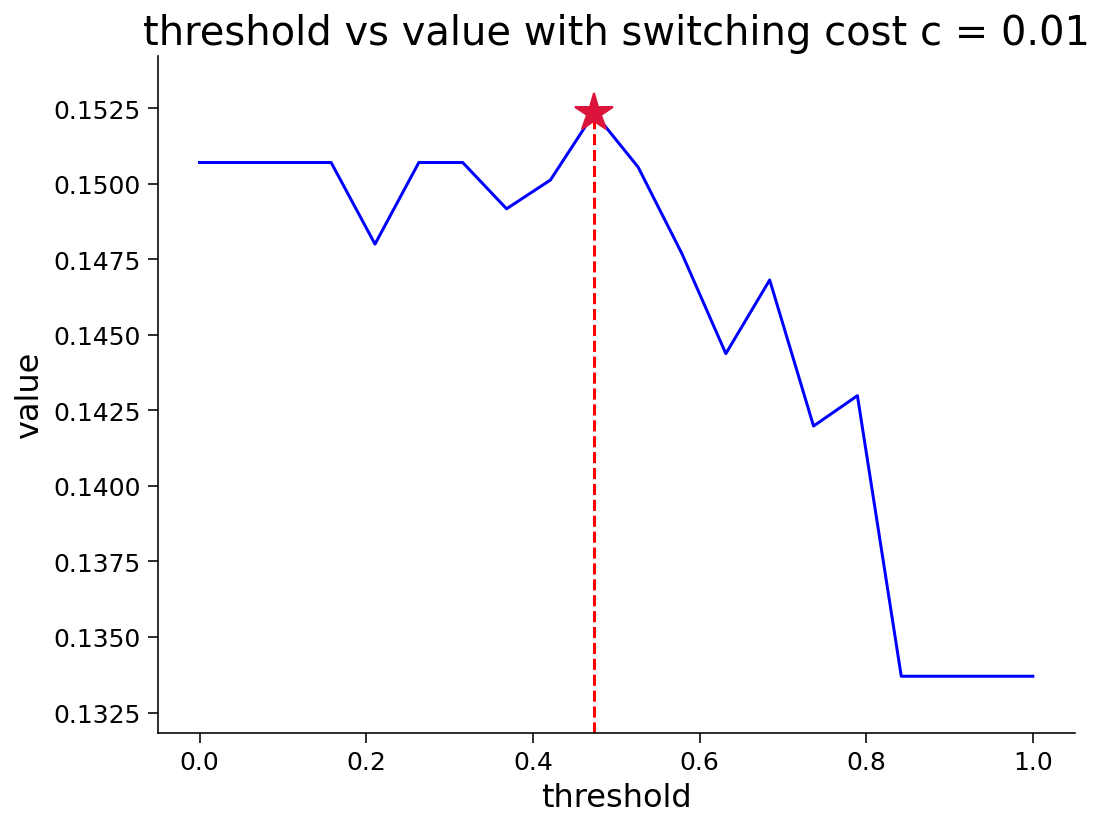

In [22]:
def run_policy(threshold, p_stay, low_rew_p, high_rew_p):
  """
  This function executes the policy (fully parameterized by the threshold) and
  returns two arrays:
    The sequence of actions taken from time 0 to T
    The sequence of rewards obtained from time 0 to T
  """
  params = [p_stay, low_rew_p, high_rew_p, threshold]
  binaryHMM_test = binaryHMM_belief(params, choose_policy="threshold")
  _, _, actions, rewards, _ = binaryHMM_test.generate_process()

  return actions, rewards

def get_optimal_threshold(p_stay, low_rew_p, high_rew_p, cost_sw):
  """
  Args:
    p_stay (float): probability of fish staying in their current location
    low_rew_p (float): probability of catching fish when you and the fist are in different locations.
    high_rew_p (float): probability of catching fish when you and the fist are in the same location.
    cost_sw (float): the cost of switching to the other location

  Returns:
    value (float): expected utility per unit time
  """
  ############################################################################
  ## 1. Modify the code below to find the best threshold using brute force
  ##
  ## 2. After completing the function, comment this line:
  #raise NotImplementedError("Student exercise: Please complete the code")
  ############################################################################
  global T
  T = 10000  # Setting a large time horizon
  get_randomness(T)

  # Create an array of 20 equally distanced candidate thresholds (min = 0., max=1.):
  threshold_array = np.linspace(0, 1, 20)

  # Using the function get_value() that you coded before and
  # the function run_policy() that we provide, compute the value of your
  # candidate thresholds:

  # Create an array to store the value of each of your candidates:
  value_array = np.zeros(len(threshold_array))

  for i in range(len(threshold_array)):
      actions, rewards = run_policy(threshold_array[i], p_stay, low_rew_p, high_rew_p)
      value_array[i] = get_value(rewards, actions, cost_sw)

  # Return the array of candidate thresholds and their respective values

  return threshold_array, value_array


# Feel free to change these parameters
stay_prob = .9
low_rew_prob = 0.1
high_rew_prob = 0.2
cost_sw = .01

# Visually determine the threshold that obtains the maximum utility
threshold_array, value_array = get_optimal_threshold(stay_prob, low_rew_prob, high_rew_prob, cost_sw)
plot_value_threshold(threshold_array, value_array)

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/main//tutorials/W3D3_OptimalControl/solutions/W3D3_Tutorial1_Solution_2020798b.py)

*Example output:*

<img alt='Solution hint' align='left' width=1137.0 height=849.0 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/tutorials/W3D3_OptimalControl/static/W3D3_Tutorial1_Solution_2020798b_0.png>



[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/main//tutorials/W3D3_OptimalControl/solutions/W3D3_Tutorial1_Solution_c478f8f8.py)



---
# Summary

In this tutorial, you combined Hidden Markov Models with actions to solve an optimal control problem! This showed us the core formalism of the *Partially Observable Markov Decision Process* (POMDP).

Using observations (fish caught), you built beliefs (posterior distributions) that helped you estimate where the fish were. Next, you computed a value function that helped you evaluate the quality of different policies. Finally, using a brute force approach, you discovered an optimal policy that allowed you to catch as many fish as possible while minimizing the effort of switching your location.

The following tutorial will use continuous states and actions instead of the binary ones we used here. In continuous control, we can still use a POMDP, but we'll focus on control in the *fully* observed case, a Markov Decision Process (MDP), since the policy is still illuminating.

In [23]:
# @title Video 6: From discrete to continuous control
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
      def __init__(self, id, page=1, width=400, height=300, **kwargs):
          self.id=id
          src = 'https://player.bilibili.com/player.html?bvid={0}&page={1}'.format(id, page)
          super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id="BV1JA411v7jy", width=854, height=480, fs=1)
  print('Video available at https://www.bilibili.com/video/{0}'.format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id="ndCMgdjv9Gg", width=854, height=480, fs=1, rel=0)
  print('Video available at https://youtube.com/watch?v=' + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

display(out)

---
# Bonus

---
## Bonus Section: How does the optimal policy depend on the task?

In [ ]:
# @title Video 7: Sensitivity of optimal policy
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
      def __init__(self, id, page=1, width=400, height=300, **kwargs):
          self.id=id
          src = 'https://player.bilibili.com/player.html?bvid={0}&page={1}'.format(id, page)
          super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id="BV1QK4y1e7N9", width=854, height=480, fs=1)
  print('Video available at https://www.bilibili.com/video/{0}'.format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id="wd8IVsKoEfA", width=854, height=480, fs=1, rel=0)
  print('Video available at https://youtube.com/watch?v=' + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

display(out)

### Bonus Interactive Demo 1

In this demo, you can play with various task parameters. Observe how the optimal threshold changes when you adjust:
* The switching cost
* The fish dynamics (`p(stay)`)
* The probability of catching fish on each side, `p(high_rwd)` and `p(low_rwd)`

Can you explain why the optimal threshold changes with these parameters:

* lower/higher switching cost?
* faster fish dynamics (_i.e._, low `p_stay`)?
* rarer fish caught (_i.e._, low `p(high_rwd)` and low `p(low_rwd)`)?

Note that it may require long simulations to see subtle changes in values of different policies, so look for coarse trends first.

In [ ]:
# @markdown Make sure you execute this cell to enable the widget!
display(HTML('''<style>.widget-label { min-width: 15ex !important; }</style>'''))

@widgets.interact(p_stay=widgets.FloatSlider(.95, description="p(stay)",
                                             min=0., max=1.),
                  p_high_rwd=widgets.FloatSlider(.4, description="p(high_rwd)",
                                                 min=0., max=1.),
                  p_low_rwd=widgets.FloatSlider(.1, description="p(low_rwd)",
                                                min=0., max=1.),
                  cost_sw=widgets.FloatSlider(.2, description="switching cost",
                                              min=0., max=1., step=.01))


def update_ex_bonus(p_stay, p_high_rwd, p_low_rwd, cost_sw):
  """
    p_stay: probability fish stay
    high_rew_p: p(catch fish) when you're on their side
    low_rew_p : p(catch fish) when you're on other side
    cost_sw: switching cost
  """

  threshold_array, value_array = get_optimal_threshold(p_stay,
                                                       p_low_rwd,
                                                       p_high_rwd,
                                                       cost_sw)
  plot_value_threshold(threshold_array, value_array)


plt.show()

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/main//tutorials/W3D3_OptimalControl/solutions/W3D3_Tutorial1_Solution_826f5513.py)

